### Data Preprocessing

In [197]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import visuals as vs

In [2]:
%matplotlib inline

In [3]:
# Read in data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


Lets analyze numerical values --Integer columns

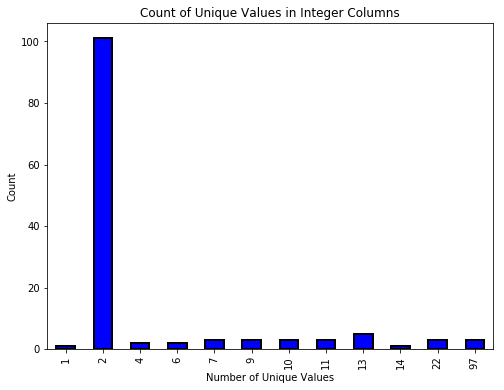

In [5]:
train.select_dtypes(include=['int64']).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

With above graph we observe that most numerical columns contains 2 unique values and it may be boolean features.

In [6]:
from collections import OrderedDict
# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

Lets analyze columns with string values

In [7]:
train.select_dtypes(include=['object']).head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


<ul>
<li>Id:  Row identifier </li>
<li>idhogar : Unique identifier for house hold</li>
Below three features contains mixed values (numbers and yes ,no).We can convert yes no into corresponding numeric values so that we can convert these columns into float type.<br>
<li>dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)</li>
<li>edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0</li>
<li>edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
</ul>

We see that for columns dependency,edjefa,edjefe values are mixed of boolean and numbers.We should convert boolean 
into numbers according to above description.

In [8]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [9]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

In [10]:
data.shape

(33413, 143)

In [11]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

In [12]:
heads.shape

(10307, 143)

In [13]:
# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

In [14]:
# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

In [15]:
from collections import OrderedDict
# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

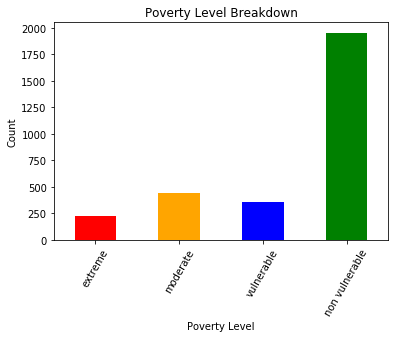

In [16]:
label_counts.plot.bar(color = colors.values())
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

Now we need to correct lables for few of the records.There might be chances of individuals of same household having different poverty levels though it must be same at household level.Lets find and correct accordingly.

In [17]:
households=train.groupby('idhogar')['Target'].nunique()>1

In [18]:
households_different_level=households[households==True]

In [19]:
len(households_different_level)

85

In [20]:
for household in households_different_level.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target

### Handling missing values

In [21]:
missing=pd.DataFrame(data.isnull().sum()).rename(columns={0:'total'})
missing['Percentage']=missing['total']/len(data)

In [22]:
missing.sort_values('Percentage',ascending=False).head(10).drop('Target')

,total,Percentage
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [23]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

Lets plot for feature v18q1:number of tablets household owns.Since its household level feature ,we will only look for counts related to head of household 

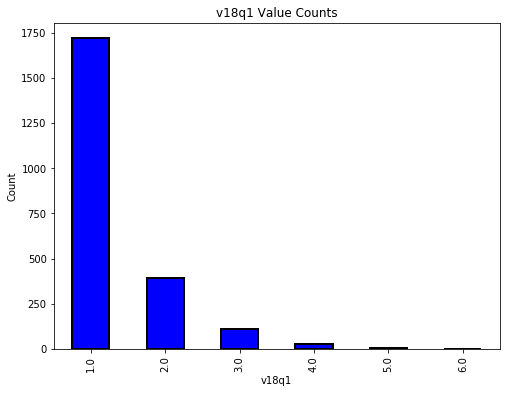

In [24]:
plot_value_counts(heads, 'v18q1')

As we notice,most frequent number is 1 which means most family owns 1 tablets,few owns 2 and very few 3 and 4 respectively.However we have a lot of missing values in this columns which may indicate that family has no tab at all.To support this derivation we must consider another feature v18 :owns a tablet (1 yes 0 no)

In [25]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

That means we can fill 0 (means family has 0 tabs) against missing records.

In [26]:
data['v18q1'] = data['v18q1'].fillna(0)

Now we are going to handle another missing value column ,v2a1: Monthly rent payment
We should consider below related variables as well to conclude on missing data for this column.<br>
tipovivi1, =1 own and fully paid house<br>
tipovivi2, "=1 own,  paying in installments" <br>
tipovivi3, =1 rented <br>
tipovivi4, =1 precarious <br>
tipovivi5, "=1 other(assigned,  borrowed)"<br>

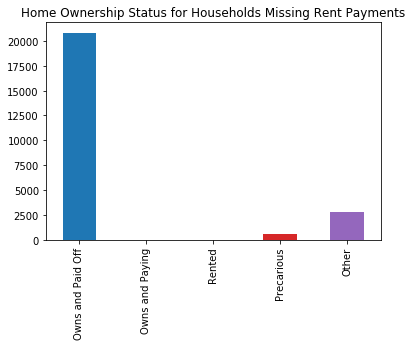

In [27]:
data.loc[data['v2a1'].isnull(),['tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5']].sum().plot.bar()
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'])
plt.title('Home Ownership Status for Households Missing Rent Payments');

In [28]:
data.loc[data['v2a1'].isnull(),['tipovivi1','tipovivi2','tipovivi3','tipovivi4','tipovivi5']].sum()

tipovivi1    20844
tipovivi2        0
tipovivi3        0
tipovivi4      597
tipovivi5     2822
dtype: int64

We can observe that mostly null values are for those who have own house.We can set monthly rental amount to 0 for them.
For other two categories,we will see other ways to handle missing data.

In [29]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

Now lets analyze another column with large number of missing values --rez_esc: years behind in school

In [30]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

In [31]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

### Feature Engineering

For this problem,we have given features for household level as well as individual level.As we need to consider target at household level,we must use some aggregation methods to group individual data into household level.<br>
There are several different categories of variables:

1) Individual Variables: these are characteristics of each individual rather than the household
<li>Boolean: Yes or No (0 or 1)</li>
<li>Ordered Discrete: Integers with an ordering</li>

2) Household variables
<li>Boolean: Yes or No</li>
<li>Ordered Discrete: Integers with an ordering</li>
<li>Continuous numeric</li>

3) Squared Variables: derived from squaring variables in the data

4) Id variables: identifies the data and should not be used as features

In [32]:
id_ = ['Id', 'idhogar', 'Target']

In [33]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [34]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [35]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


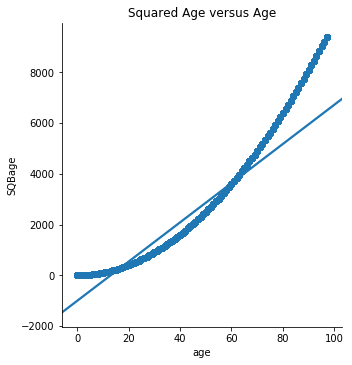

In [36]:
sns.lmplot('age', 'SQBage', data = data);
plt.title('Squared Age versus Age');

As we see,both variables are highly corelated to each other.In similar way hence we can conclude and remove all squared variables

In [37]:
# Remove squared variables
data=data.drop(['SQBescolari','SQBage','SQBhogar_total','SQBedjefe','SQBhogar_nin','SQBovercrowding','SQBdependency','SQBmeaned','agesq'],axis=1)
data.shape

(33413, 136)

In [38]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

There 99 features are household features hence we can keep as it is for training and prediction.We will try to eliminate redundant  features if any.

In [39]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

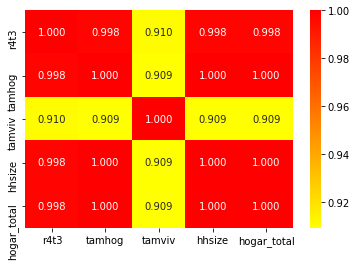

In [40]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

Description of these corelated variables are as follows
<li>r4t3, Total persons in the household</li>
<li>tamhog, size of the household</li>
<li>tamviv, number of persons living in the household</li>
<li>hhsize, household size</li>
<li>hogar_total,  of total individuals in the household</li>

Above heatmap suggests that tamhog,hogar_total,r4t3 and hh_size is highly corelated with each other.Hence we can keep one and remove others from our feature list

In [41]:
heads = heads.drop( ['tamhog', 'hogar_total', 'r4t3'],axis=1)

tamviv and hhsize might have some interesting relationship with each other as both variables have different meaning in this context.

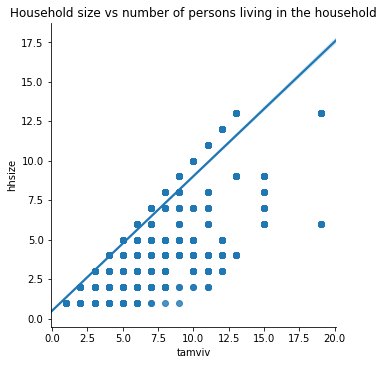

In [42]:
sns.lmplot('tamviv', 'hhsize', data);
plt.title('Household size vs number of persons living in the household');

above graph shows one very interesting property here : no of person living in household is grater than household size and this relationship may play significant role in predicting poverty lavel--larger the difference more are the chances of vulnerability.
Lets create a feature for this

In [43]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']

In [44]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

Lets analyze another redundant variable: coopele

In [45]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


To understand relationship of above 2 corelated variables,we need to consider other two features which provide information on electricity sources

<li>public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC"</li>
<li>planpri, =1 electricity from private plant</li>
<li>noelec, =1 no electricity in the dwelling</li>
<li>coopele, =1 electricity from cooperative</li>

Rather than keeping different features for same information,we can combine these and create one ordinal feature(one number for each category):

0: No electricity<br>
1: Electricity from cooperative<br>
2: Electricity from CNFL, ICA, ESPH/JASEC<br>
3: Electricity from private plant<br>


In [46]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()



In [47]:
# Remove the electricity columns
heads = heads.drop(['noelec', 'coopele', 'public', 'planpri'],axis=1)

Now lets have a look into another duplicate columns:
    
<li>area1, =1 zona urbana</li>
<li>area2, =2 zona rural</li>

We can drop one column as both of them provides same information and keeping one of them will be enough.

In [48]:
heads = heads.drop('area2',axis=1)

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

We can convert below features into ordinal features

<li>epared1, =1 if walls are bad</li>
<li>epared2, =1 if walls are regular</li>
<li>epared3, =1 if walls are good</li>
<li>etecho1, =1 if roof are bad</li>
<li>etecho2, =1 if roof are regular</li>
<li>etecho3, =1 if roof are good</li>
<li>eviv1, =1 if floor are bad</li>
<li>eviv2, =1 if floor are regular</li>
<li>eviv3, =1 if floor are good</li>

We can assign numbers 0,1,2 for bad,regular and good respectively.

In [49]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

In [50]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)


In [51]:
heads = heads.drop(['etecho1', 'etecho2', 'etecho3'],axis=1)
heads = heads.drop(['eviv1', 'eviv2', 'eviv3'],axis=1)
heads = heads.drop(['epared1', 'epared2', 'epared3'],axis=1)

We can sum walls,roofs and floor and create a new feature which might represent overall house quality. 

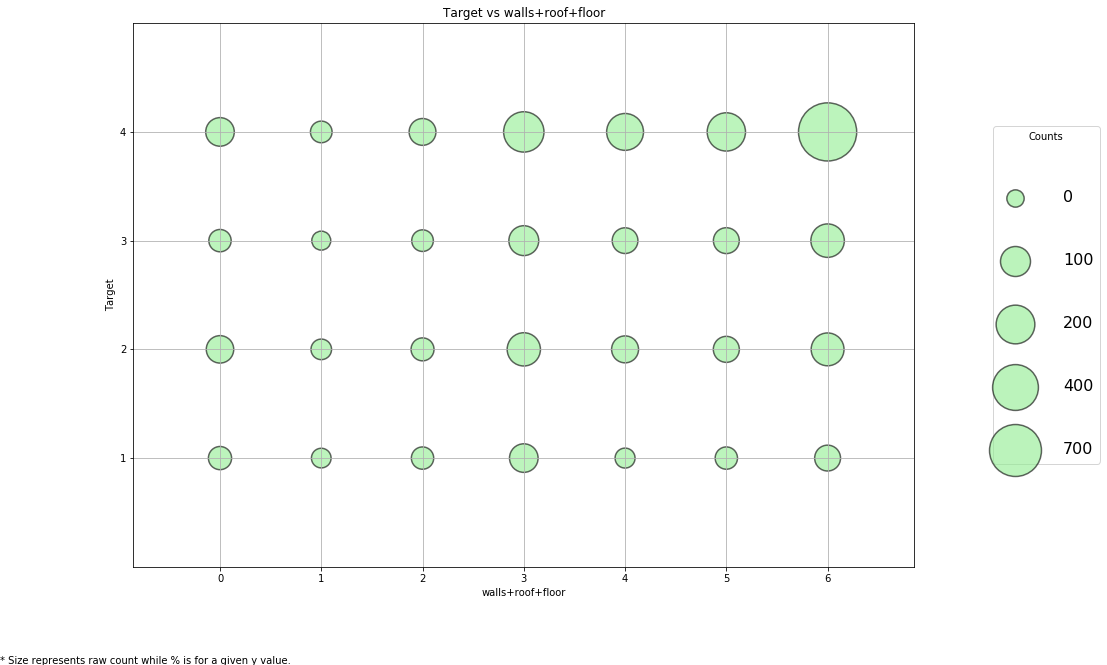

In [52]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

We notice that for target 4: non vulnerable,counts increases as overall house quality increases. 

We can create other meaningful features as well such as warning by giving 1 point to each (No toilet, no electricity, no floor, no water service, no ceiling)

In [53]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

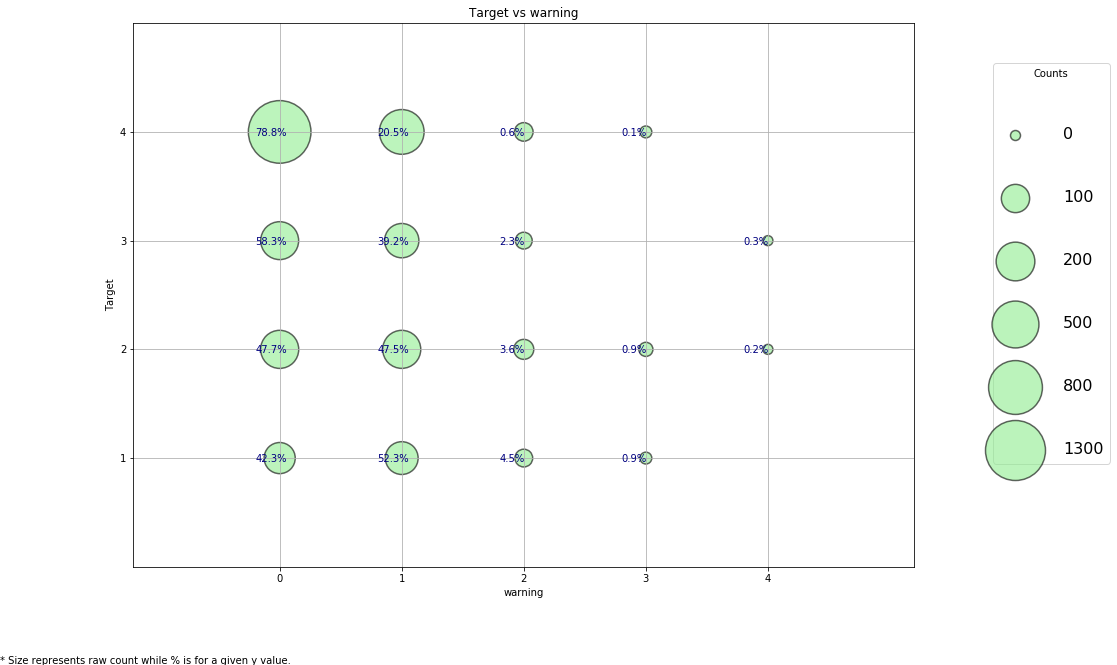

In [54]:
plot_categoricals('warning', 'Target', data = heads)

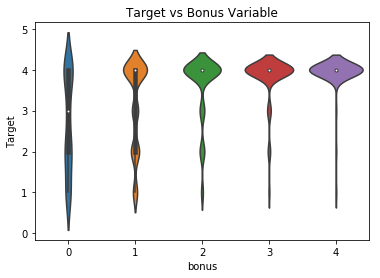

In [55]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));
plt.title('Target vs Bonus Variable');

Lets engineer couple of other household features

In [56]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

In [57]:
#only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

<li>The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables></li>
<li>The Spearman Correlation: from -1 to 1 measuring the monotonic relationship between two variables</li>

In [58]:
pcorrs =pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns={'Target': 'pcorr'}).reset_index()

In [59]:
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head())

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail())

Most negatively correlated variables:
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4          r4m1 -0.209479

Most positively correlated variables:
              feature     pcorr
87  phones-per-capita  0.299026
88              floor  0.307605
89   walls+roof+floor  0.332446
90           meaneduc  0.333652
91             Target  1.000000


Negative correlation means if one variable increases other decreases and vice versa.As we can see from above,warning and target and negatively correlated.As value of warning increases,Target decreases:poverty level increases(0-4 with 4 is non-vulnerable).

In similar way,as features like phone-per-capita,floor and meaneduc increases,target increases: poverty decreases.

Now lets evaluate Spearman Correlation so that we can idenitfy if there is any non-linear dependency between taregt and other feature.

In [60]:
from scipy.stats import spearmanr

In [61]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

In [62]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
        feature     scorr        pvalue
87      warning -0.307326  4.682829e-66
58   dependency -0.281516  2.792620e-55
75    hogar_nin -0.236225  5.567218e-39
70         r4t1 -0.219226  1.112230e-33
8   pisocemento -0.209387  8.270816e-31

Most positive Spearman correlations:
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
85              floor  0.309638  4.466091e-67
89  phones-per-capita  0.337377  4.760104e-80
86   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


As we see,both values are similar for most of the features.We can find and address if there is any big difference in both values:

In [63]:
corrs = pcorrs.merge(scorrs, on = 'feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pvalue,diff
69,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
77,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
79,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
87,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [64]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pvalue,diff
50,techozinc,0.014357,0.003404,8.528369e-01,0.010954
44,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
80,edjefe,0.235687,0.214736,2.367521e-32,0.020951
58,edjefa,0.052310,0.005114,7.804715e-01,0.047197
13,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


As we see dependency has some difference in pcorr and scorr.We can see relationship of this features with other features and taregt seperately.

In [65]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

We can always draw heatmap to quickly observe corrlation.

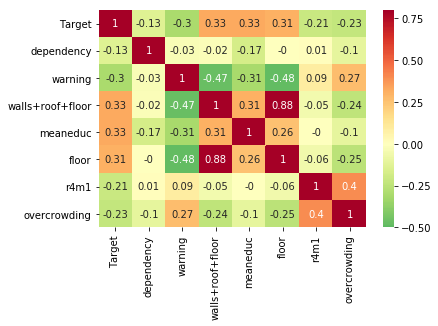

In [66]:
# Calculate the correlations
corr_mat = train_heads[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 10
#plt.figure(figsize = (8,8))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

As we see ,floor and walls+roof+floor features are highly corralted to each other.We might want to delete one of them in case of any performance issue in model.

In [67]:
household_feats = list(heads.columns)

#### Individual Level Variables

In [68]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

We can see correlation in individual level features(most of them are boolean and ordinal) and eliminate redundant features.

In [69]:
# Create correlation matrix
corr_matrix = ind.corr()

In [70]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

In [71]:
ind = ind.drop( ['male'],axis=1)

Now we can take boolean features and can convert to ordinal variables wherever applicable.

<li>instlevel1, =1 no level of education</li>
<li>instlevel2, =1 incomplete primary</li>
<li>instlevel3, =1 complete primary</li>
<li>instlevel4, =1 incomplete academic secondary level</li>
<li>instlevel5, =1 complete academic secondary level</li>
<li>instlevel6, =1 incomplete technical secondary level</li>
<li>instlevel7, =1 complete technical secondary level</li>
<li>instlevel8, =1 undergraduate and higher education</li>
<li>instlevel9, =1 postgraduate higher education</li>

As we can convert these features into an ordinal feature as these columns reflects level of education in particular order order.

In [72]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

In [73]:
ind['inst'].head()

0    3
1    7
2    4
3    3
4    4
Name: inst, dtype: int64

C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


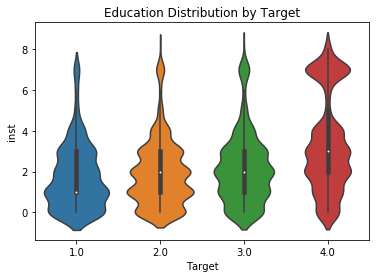

In [74]:
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');

In [75]:
# Drop the education columns
ind = ind.drop( [c for c in ind if c.startswith('instlevel')],axis=1)
ind.shape

(33413, 31)

In [76]:
ind.head()

,Id,idhogar,Target,v18q,dis,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,...,parentesco9,parentesco10,parentesco11,parentesco12,mobilephone,rez_esc-missing,rez_esc,escolari,age,inst
0,ID_279628684,21eb7fcc1,4.0,0,0,0,0,0,0,1,...,0,0,0,0,1,False,0.0,10,43,3
1,ID_f29eb3ddd,0e5d7a658,4.0,1,0,0,0,0,0,1,...,0,0,0,0,1,False,0.0,12,67,7
2,ID_68de51c94,2c7317ea8,4.0,0,1,1,0,0,0,0,...,0,0,0,0,0,False,0.0,11,92,4
3,ID_d671db89c,2b58d945f,4.0,1,0,0,0,0,0,0,...,0,0,0,0,1,False,1.0,9,17,3
4,ID_d56d6f5f5,2b58d945f,4.0,1,0,1,0,1,0,0,...,0,0,0,0,1,False,0.0,11,37,4


Now we need to aggregate individual level features into household level.We can use aggregate functions to do so.

In [77]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop('Target',axis=1).groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...    age        \
           min max sum count  std range_ min max sum count  ...    sum count   
idhogar                                                     ...                
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...     62     3   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...    123     2   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...    142     4   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...     38     2   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...     51     4   

                            inst                                 
                 std range_  min max sum count       std range_  
idhogar                                                          
000a08204  14.468356     26    0   7  14     3  4.041452      7  
000bce7c4   2.121320      3    0   1   1     2  0.707107      1  
001845fb0  16.421531     33    2   7  16     4  2.160247      5  
001ff74ca  26.870058     38    0   7   7     2  4.949747      7  
003123ec2  12.446552     23    0   3   5     4  1.500000      3  

[5 rows x 162 columns]

In [78]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col

In [79]:
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,62,3,14.468356,26,0,7,14,3,4.041452,7
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,123,2,2.121320,3,0,1,1,2,0.707107,1
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,142,4,16.421531,33,2,7,16,4,2.160247,5
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,38,2,26.870058,38,0,7,7,2,4.949747,7
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,51,4,12.446552,23,0,3,5,4,1.500000,3


Now lets remove redundant features using correlation.

In [80]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 79 correlated columns to remove.


In [81]:
ind_agg = ind_agg.drop(to_drop,axis=1)
ind_feats = list(ind_agg.columns)

In [82]:
ind_agg.shape

(10340, 83)

In [83]:
heads.shape

(10307, 95)

In [84]:
ind_agg.reset_index(level=0, inplace=True)

In [85]:
# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')
print('Final features shape: ', final.shape)

Final features shape:  (10307, 178)


In [86]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,...,NaN,0,43,43,43,NaN,0,3,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,...,NaN,0,67,67,67,NaN,0,7,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,...,NaN,0,92,92,92,NaN,0,4,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,...,4.272002,9,8,38,100,14.899664,30,4,1.414214,3
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,...,5.123475,11,7,30,76,11.690452,23,4,1.825742,4


### Modelling

First we will create out of the box model and later try to tune it.

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')


In [88]:
# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

In [89]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(['Id', 'idhogar', 'Target'],axis=1)
test_set = final[final['Target'].isnull()].drop(['Id', 'idhogar','Target'],axis=1)

In [90]:
test_set.shape,train_set.shape

((7334, 175), (2973, 175))

Before we start modeling our data,its important to replace null values with some candidate vales(mean ,median etc) and scale the features

In [91]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [92]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(train_set
                                                      , train_labels,stratify=train_labels,test_size=0.2, random_state=1)

In [94]:
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_valid.shape[0]))

Training set has 2378 samples.
Testing set has 595 samples.


##### Trainging and predcting pipeline
 
Now lets create a training_predict pipeline in order to quickly train few out supervised learning models and select which performs best.

In [95]:
from sklearn.metrics import accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = f1_score(y_train[:300],predictions_train,average='macro')
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = f1_score(y_test,predictions_test,average='macro')
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [96]:
accuracy=0
fscore=0
from time import time

#### BaseLine Model

In [97]:
basemodel=RandomForestClassifier(random_state=2)
basemodel.fit(X_train,y_train)
preds=basemodel.predict(X_valid)

C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [98]:
f1_score(y_valid, preds, average='macro'),accuracy_score(y_valid, preds)

(0.3463950433196288, 0.6436974789915967)

We got baseline model with F1_score 0.34 and accuracy score 0.643 ;will try to get better score after model tuning or choosing different algorithms in case if we get better performance.

C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


DecisionTreeClassifier trained on 23 samples.
DecisionTreeClassifier trained on 237 samples.
DecisionTreeClassifier trained on 2378 samples.


C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AdaBoostClassifier trained on 23 samples.
AdaBoostClassifier trained on 237 samples.
AdaBoostClassifier trained on 2378 samples.
RandomForestClassifier trained on 23 samples.
RandomForestClassifier trained on 237 samples.
RandomForestClassifier trained on 2378 samples.


C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\abhishek.u.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


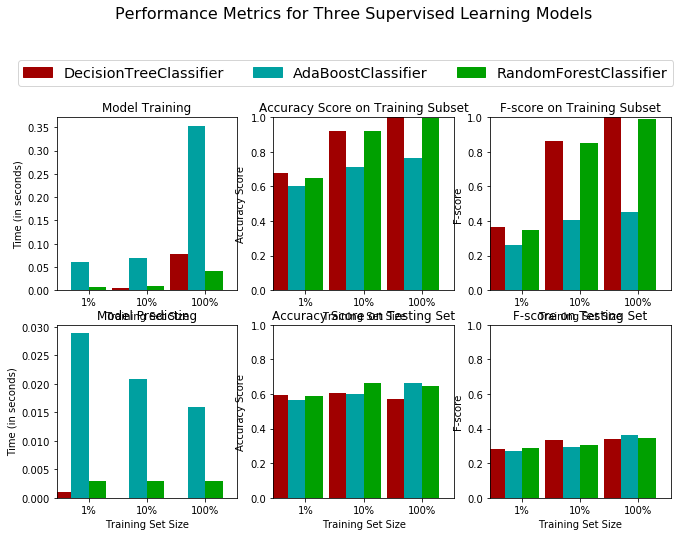

In [99]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
# Initialize the three models
clf_A = DecisionTreeClassifier(random_state=2)
clf_B = AdaBoostClassifier(random_state=2)
clf_C = RandomForestClassifier(random_state=2)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100*0.1)
samples_1 = int(samples_100*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_valid, y_valid)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

We notice that Adaboost classifier gets best F1 score among three chosen models.We will select and try to tune it to get higher score.

In [100]:
results['RandomForestClassifier'][2]

{'train_time': 0.041857004165649414,
 'pred_time': 0.0029909610748291016,
 'acc_train': 0.9933333333333333,
 'acc_test': 0.6436974789915967,
 'f_train': 0.9884572072072072,
 'f_test': 0.3463950433196288}

In [101]:
results['AdaBoostClassifier'][2]

{'train_time': 0.354050874710083,
 'pred_time': 0.01595592498779297,
 'acc_train': 0.7666666666666667,
 'acc_test': 0.6621848739495798,
 'f_train': 0.45350482850482854,
 'f_test': 0.36137630824249856}

In [102]:
clf_B

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=2)

In [103]:
import warnings
warnings.filterwarnings('ignore')

In [127]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# Initialize the classifier

#clf = RandomForestClassifier(random_state=2)

#clf=AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_features = "auto", class_weight = "balanced",max_depth = None))
clf=AdaBoostClassifier(random_state=2)

parameters = {
    'n_estimators': [40,50,60,70,80],
    'learning_rate':[0.1,0.5, 1],
    #"base_estimator__criterion" : ["gini", "entropy"],
    #"base_estimator__splitter" :["best", "random"],
    #'base_estimator__max_depth':[1,2,3],
    #'base_estimator__min_samples_split':[5,10,20,30,40],
    }

#parameters = {'n_estimators':[10,20,30],'max_depth':[2,3,4,5]}
# Make an fbeta_score scoring object using make_scorer()
#scorer = make_scorer(fbeta_score,beta=0.5)
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
                       
grid_obj = GridSearchCV(clf,parameters,scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_valid)
best_predictions = best_clf.predict(X_valid)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_valid, predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_valid, predictions, average='macro')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_valid, best_predictions, average='macro')))

Unoptimized model
------
Accuracy score on testing data: 0.6622
F-score on testing data: 0.3614

Optimized Model
------
Final accuracy score on the testing data: 0.6622
Final F-score on the testing data: 0.3850


In [128]:
best_clf

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=80, random_state=2)

In [182]:
submission_base.shape

(23856, 2)

In [197]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

In [195]:
predictions_test = best_clf.predict(test_set)

In [196]:
predictions_test

array([4, 4, 4, ..., 4, 4, 2])

In [200]:
predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions_test})

In [201]:
submission = submission_base.merge(predictions,on = 'idhogar',how = 'left').drop(columns = ['idhogar'])
submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

In [202]:
submission.to_csv('submission.csv', index = False)

In [206]:
#model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),random_state=2)
#model.fit(X_train,y_train)
# Extract the feature importances using .feature_importances_ 
#importances = model.feature_importances_


#### Robustness test

In [106]:
from sklearn.model_selection import cross_val_score

In [129]:
# 10 fold cross validation
cv_score = cross_val_score(best_clf, train_set, train_labels, cv = 10, scoring = scorer)
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3131 with std = 0.0692


In [115]:
cv_score

array([0.42725468, 0.36702904, 0.34736981, 0.33365746, 0.33010582,
       0.29556989, 0.22739396, 0.19094201, 0.24541343, 0.36667442])

In [119]:
# 10 fold cross validation
cv_score_rf = cross_val_score(clf_C, train_set, train_labels, cv = 10, scoring = scorer)
print(f'10 Fold Cross Validation F1 Score = {round(cv_score_rf.mean(), 4)} with std = {round(cv_score_rf.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3623 with std = 0.0471


In [120]:
cv_score_rf

array([0.40310323, 0.30136726, 0.40055005, 0.35062247, 0.44859874,
       0.3754893 , 0.31421287, 0.29761721, 0.34204311, 0.38922931])

#### Varying random state

In [139]:
clf_Adaboost = AdaBoostClassifier(random_state=10,n_estimators=80,learning_rate=1)

In [141]:
X_train, X_valid, y_train, y_valid = train_test_split(train_set
                                                      , train_labels,stratify=train_labels,test_size=0.2, random_state=10)

In [142]:
clf_Adaboost.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=80, random_state=10)

In [143]:
predictions_ab = clf_Adaboost.predict(X_valid)

print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, predictions_ab)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_valid, predictions_ab, average='macro')))

Final accuracy score on the testing data: 0.6252
Final F-score on the testing data: 0.3516


In [144]:
X_train, X_valid, y_train, y_valid = train_test_split(train_set
                                                      , train_labels,stratify=train_labels,test_size=0.2, random_state=20)

In [145]:
clf_Adaboost.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=80, random_state=10)

In [146]:
predictions_ab = clf_Adaboost.predict(X_valid)

print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, predictions_ab)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_valid, predictions_ab, average='macro')))

Final accuracy score on the testing data: 0.6622
Final F-score on the testing data: 0.3545


#### Feature importance

In [203]:
importances = best_clf.feature_importances_

In [205]:
importances.sum()

1.0

In [206]:
# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances.head()

,feature,importance
0,hacdor,0.0
1,hacapo,0.0
2,v14a,0.0
3,refrig,0.0
4,paredblolad,0.0


In [207]:
#X=pd.DataFrame(X_train,columns=features)

In [213]:
def plot_feature_importances(df, n = 15, threshold = None):
   
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'lightblue', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

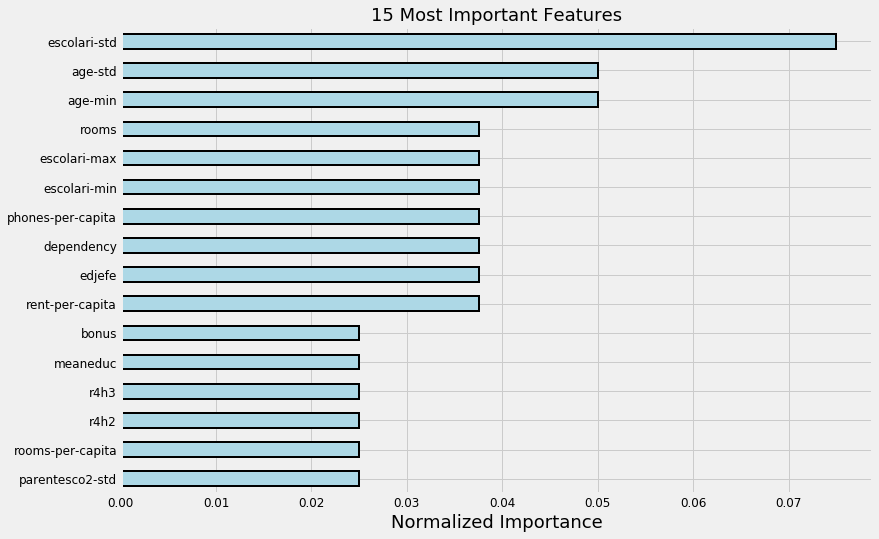

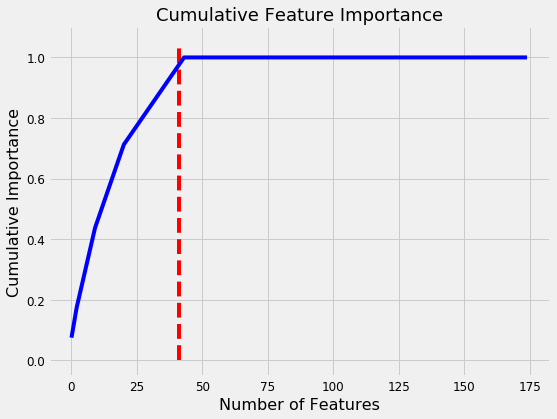

41 features required for 95% of cumulative importance.


In [214]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)